<a href="https://colab.research.google.com/github/puja-maitra/Unclear/blob/main/Sketch_to_colour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install kaggle

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [4]:
!kaggle datasets download 'ktaebum/anime-sketch-colorization-pair'

100% 11.6G/11.6G [04:48<00:00, 7.93MB/s]
100% 11.6G/11.6G [04:48<00:00, 43.3MB/s]


In [5]:
import os                            #to interact with the operating system
import time
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = 'C:/Users/ukpuj/Downloads/gdrive/MyDrive/kaggle'

In [6]:
os.listdir()

['.config', 'anime-sketch-colorization-pair.zip', 'gdrive', 'sample_data']

In [7]:
!unzip -q 'anime-sketch-colorization-pair.zip'

In [8]:
os.getcwd()

'/content'

In [9]:
os.listdir()

['.config',
 'anime-sketch-colorization-pair.zip',
 'data',
 'gdrive',
 'sample_data']

In [10]:
import tensorflow as tf

import matplotlib.pyplot as plt

#change PATH variable to absolute/relative  path to the images directory on machine which would contain the train and val folders

PATH = '/content/data'              #add path after where done downloading

#defining training variables

EPOCHS = 10    # any more and my machine's gonna d-word although recommended in actual project would be 100+ easily
BUFFER_SIZE = 100    #best buffer size is supposed to be equal to the size of the training dataset but that takes a lot of processing power
BATCH_SIZE = 32   #smaller batch size preffered i think, 4 in example codes
IMG_WIDTH = 256
IMG_HEIGHT = 256  #finally things that can stay as is

In [11]:
#defining function load() that would return the sketch b&w as input_image and the real image as both are in one image in the dataset

def load(image_file):

  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)

  w = tf.shape(image)[1]

  w = w//2

  real_image = image[ : , :w , : ]                     #takes first half of the image
  input_image = image[ : , w: , : ]                    #takes second half of the image


  input_image = tf.cast(input_image , tf.float32)
  real_image = tf.cast(real_image , tf.float32)        #tf.cast casts the tensor to the specified dtype


  return input_image , real_image 

In [12]:
#PREPROCESSING THE DATA (normalization, resizing etc.)

def resize(input_image , real_image , height , width):
  input_image = tf.image.resize(input_image , [height , width] , method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image , [height , width] , method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image , real_image

def random_crop(input_image , real_image):
  stacked_image = tf.stack([input_image,real_image] , axis = 0)
  cropped_image = tf.image.random_crop(stacked_image , size = [2, IMG_HEIGHT , IMG_WIDTH ,3])

  return cropped_image[0] , cropped_image[1]

def normalize(input_image , real_image):
  input_image = (input_image/127.5) - 1
  real_image = (real_image/127.5) - 1

  return input_image , real_image

@tf.function()

def random_jitter(input_image , real_image):                            #previous preprocessing functions are used together and random images flipped horizontally
  input_image, real_image = resize(input_image , real_image , 286 , 286)
  input_image , real_image = random_crop(input_image , real_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image , real_image

In [13]:
#loading the test and train data

def load_image_train(image_file):           # outputs final preprocessed image
  input_image , real_image = load(image_file)
  input_image , real_image = random_jitter(input_image , real_image)
  input_image , real_image = normalize(input_image , real_image)

  return input_image , real_image

train_dataset = tf.data.Dataset.list_files(PATH + '/train/*.png')            # collects path to all png files available in the train/ folder of the dataset
train_dataset = train_dataset.map(load_image_train , num_parallel_calls = tf.data.experimental.AUTOTUNE)    #collection of the paths is mapped through and each path is sent individually as an argument to the load_image_train() function which returns the final preprocessed image and adds it to the train_dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)            #shuffled and divided into mini batches

#none of the preprocessing except resize and normalize is required for the test dataset obviously


In [14]:
def load_image_test(image_file):
  input_image , real_image = load(image_file)
  input_image , real_image = resize(input_image , real_image , IMG_HEIGHT , IMG_WIDTH)

  input_image , real_image = normalize(input_image , real_image)
  
  return input_image , real_image

test_dataset = tf.data.Dataset.list_files(PATH + '/val/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)
  

In [15]:
#Building the generator model
#here
OUTPUT_CHANNELS = 3

def downsample(filters , size , shape , apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0. , 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters , size , strides = 2 , padding = 'same' , batch_input_shape = shape ,
                             kernel_initializer = initializer , use_bias = False))
  
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters , size , shape , apply_dropout = False):
  initializer = tf.random_normal_initializer(0. , 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters , size , strides=2 , padding ='same' , batch_input_shape = shape , 
                             kernel_initializer = initializer , use_bias = False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def buildGenerator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, (None, 256, 256, 3), apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4, (None, 128, 128, 64)), # (bs, 64, 64, 128)
        downsample(256, 4, (None, 64, 64, 128)), # (bs, 32, 32, 256)
        downsample(512, 4, (None, 32, 32, 256)), # (bs, 16, 16, 512)
        downsample(512, 4, (None, 16, 16, 512)), # (bs, 8, 8, 512)
        downsample(512, 4, (None, 8, 8, 512)), # (bs, 4, 4, 512)
        downsample(512, 4, (None, 4, 4, 512)), # (bs, 2, 2, 512)
        downsample(512, 4, (None, 2, 2, 512)), # (bs, 1, 1, 512)  , this would be the input for the upstack after gettin /2
    ]

    up_stack = [
        upsample(512, 4, (None, 1, 1, 512), apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, (None, 2, 2, 1024), apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, (None, 4, 4, 1024), apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4, (None, 8, 8, 1024)), # (bs, 16, 16, 1024)
        upsample(256, 4, (None, 16, 16, 1024)), # (bs, 32, 32, 512)
        upsample(128, 4, (None, 32, 32, 512)), # (bs, 64, 64, 256)
        upsample(64, 4, (None, 64, 64, 256)), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0. , 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS , 4 , strides = 2 , padding = 'same' , kernel_initializer = initializer , activation = 'tanh')  # outputs (bs , 256 , 256 , 3)

    x = inputs 

    skips = []

    for down in down_stack:
      x = down(x)
      skips.append(x)

    skips = reversed(skips[:-1])

    for up , skip in zip(up_stack, skips):
      x = up(x)
      x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs = inputs , outputs = x)
  
generator = buildGenerator()

In [16]:
#building the discriminator model
def downs(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def buildDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downs(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downs(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downs(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  
discriminator = buildDiscriminator()

In [17]:

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [19]:
checkpoint_dir = './Sketch2Color_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [21]:
#logging the losses
import datetime
log_dir="Sketch2Coloe_logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [22]:
#summary

@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [23]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)


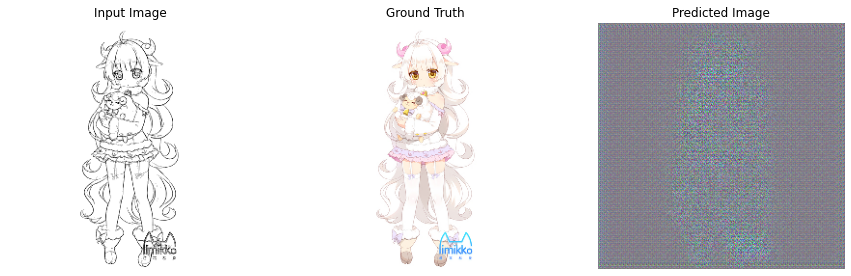

Epoch:  0
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 1 is 352.9537868499756 sec



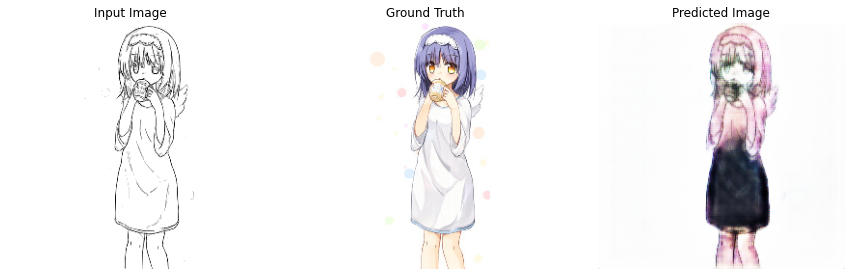

Epoch:  1
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 2 is 302.09014081954956 sec



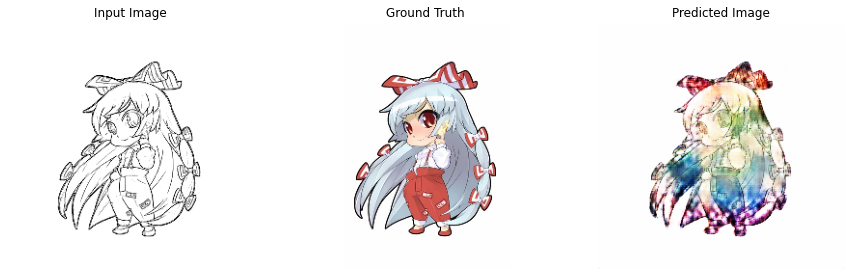

Epoch:  2
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 3 is 295.4069468975067 sec



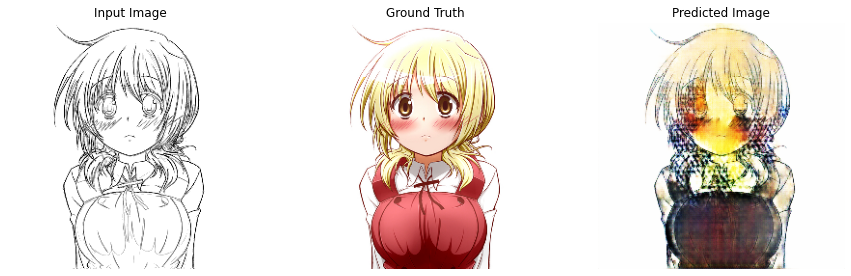

Epoch:  3
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 4 is 295.7760179042816 sec



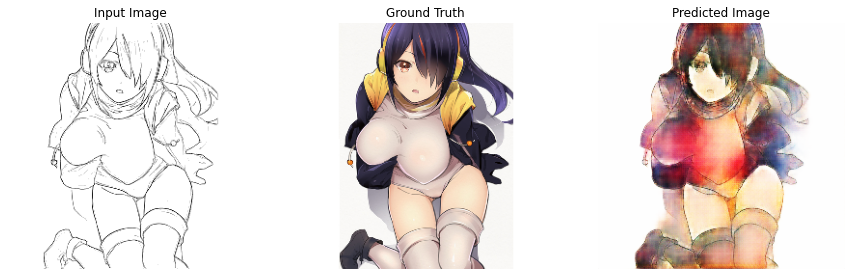

Epoch:  4
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 5 is 297.11965584754944 sec



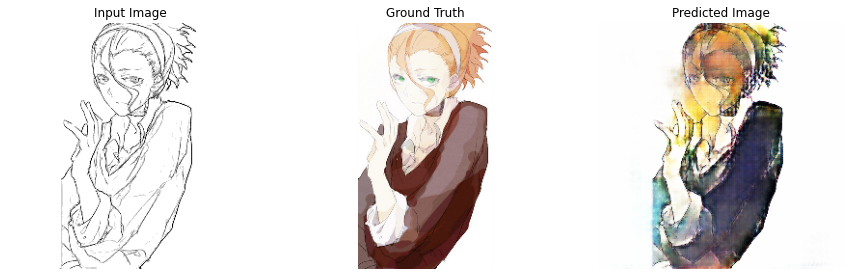

Epoch:  5
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 6 is 297.7223491668701 sec



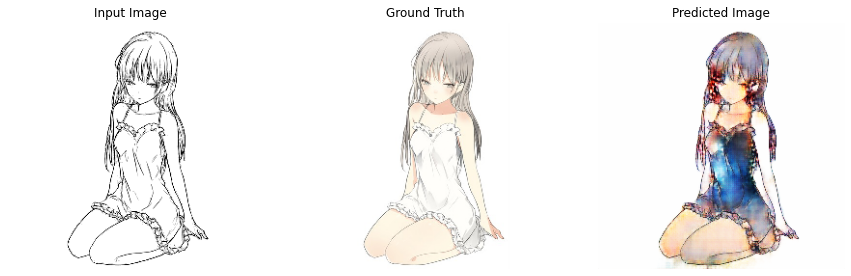

Epoch:  6
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 7 is 298.58970189094543 sec



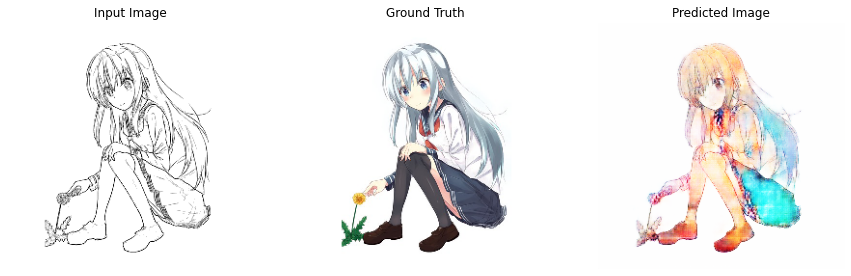

Epoch:  7
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 8 is 300.6369171142578 sec



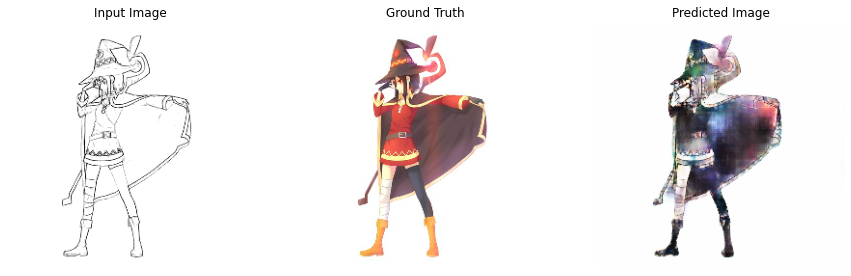

Epoch:  8
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 9 is 297.08252334594727 sec



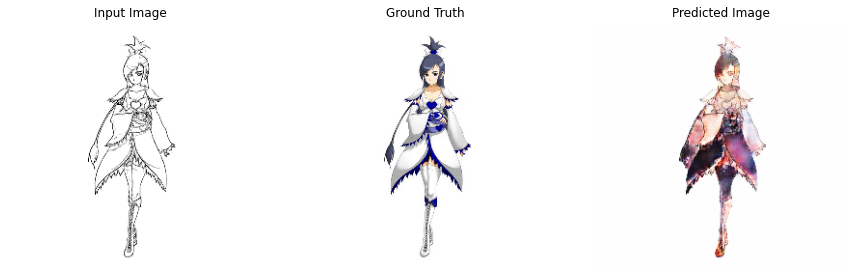

Epoch:  9
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 10 is 301.67185258865356 sec



In [24]:
fit(train_dataset, EPOCHS, test_dataset)

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

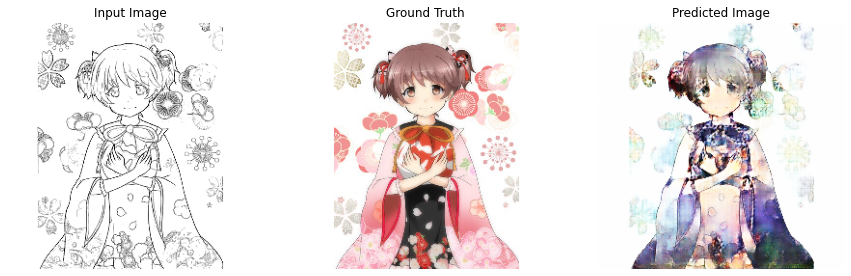

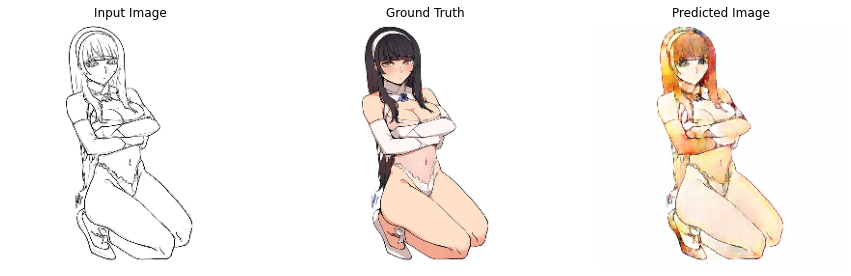

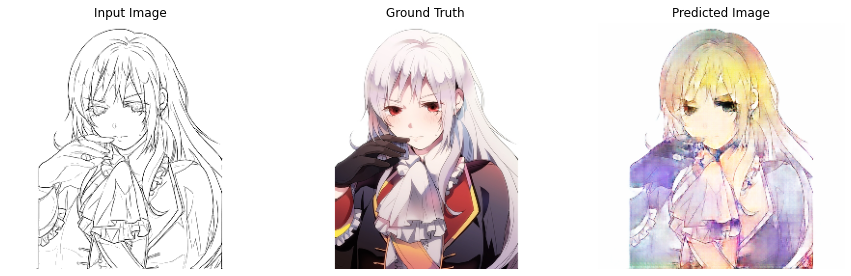

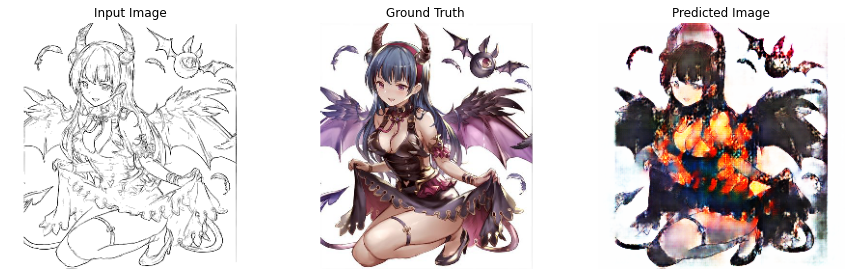

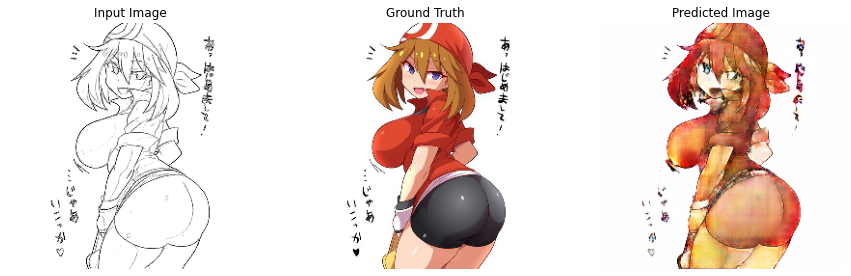

In [26]:
for example_input, example_target in test_dataset.take(5):
    generate_images(generator, example_input, example_target)